# ロジスティック回帰

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## 訓練データ生成
　　正規分布に従う乱数に基づいて中心をずらしてそれぞれ点群を発生させ、中心位置に合わせて2クラス｛0，1｝に分類する

In [3]:
n_sample = 100
harf_n_sample = 50
var = .2

def gen_data(n_sample, harf_n_sample):
    x0 = np.random.normal(size=n_sample).reshape(-1, 2) - 1.
    x1 = np.random.normal(size=n_sample).reshape(-1, 2) + 1.
    x_train = np.concatenate([x0, x1])
    y_train = np.concatenate([np.zeros(harf_n_sample), np.ones(harf_n_sample)]).astype(np.int)
    return x_train, y_train

def plt_data(x_train, y_train):
    plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, facecolor="none", edgecolor="b", s=50, label="training data")
    plt.legend()

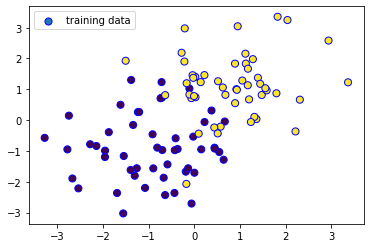

In [4]:
#データ作成
x_train, y_train = gen_data(n_sample, harf_n_sample)
#データ表示
plt_data(x_train, y_train)

## ロジスティック回帰モデル

識別モデルとして$p(y=1 | \boldsymbol{x}; \boldsymbol{w}) = \sigma (\boldsymbol{w}^{\mathrm{T}} \boldsymbol{x})$を用いる。

ただし、$\sigma(\cdot)$はシグモイド関数であり、$\sigma(h) = \frac{1}{1 + \exp{(-h)}}$で定義される。

また、陽には書かないが、$\boldsymbol{x}$には定数項のための$1$という要素があることを仮定する。

## 学習

訓練データ$X = [\boldsymbol{x}_{1}, \boldsymbol{x}_{2}, ..., \boldsymbol{x}_{n}]^{\mathrm{T}}, \boldsymbol{y} = [y_{1}, y_{2}, ..., y_{n}]^{\mathrm{T}} (y_{i} = \{0, 1\})$に対して尤度関数$L$は以下のように書ける。

$L(\boldsymbol{w}) = \prod_{i=1}^{n} p(y_{i}=1 | \boldsymbol{x}_{i}; \boldsymbol{w})^{y_{i}} (1 - p(y_{i}=1 | \boldsymbol{x}_{i}; \boldsymbol{w}))^{1 - y_{i}}$

負の対数尤度関数は

$- \log{L(\boldsymbol{w})} = - \sum_{i=1}^{n} \left[ y_{i} \log{p(y_{i}=1 | \boldsymbol{x}_{i}; \boldsymbol{w})} + (1 - y_{i}) \log{(1 - p(y_{i}=1 | \boldsymbol{x}_{i}; \boldsymbol{w}))} \right]$

のように書ける。 これを最小化する$\boldsymbol{w}$を求める。

$\frac{d \sigma(h)}{d h} = \sigma(h)(1 - \sigma(h))$と書けることを考慮し、負の対数尤度関数を$\boldsymbol{w}$で偏微分すると、

\begin{eqnarray}
\frac{\partial }{\partial \boldsymbol{w}} (-\log{L(\boldsymbol{w})}) &=& -\sum_{i=1}^{n} \left[ y_{i} (1 - \sigma(\boldsymbol{w}^{\mathrm{T}} \boldsymbol{x}_{i})) - (1 - y_{i}) \sigma(\boldsymbol{w}^{\mathrm{T}} \boldsymbol{x}_{i}) \right] \boldsymbol{x}_{i}  \\
&=& \sum_{i=1}^{n} \left( \sigma(\boldsymbol{w}^{\mathrm{T}} \boldsymbol{x}_{i}) - y_{i} ) \right) \boldsymbol{x}_{i}
\end{eqnarray}

この式が$0$となる$\boldsymbol{w}$は解析的に求められないので、今回は$-\log{L(\boldsymbol{w})}$の最小化問題を最急降下法を用いて解く。

最急降下法では学習率を$\eta$とすると、以下の式で$\boldsymbol{w}$を更新する。

$\boldsymbol{w} \leftarrow \boldsymbol{w} - \eta \frac{\partial }{\partial \boldsymbol{w}} (-\log{L(\boldsymbol{w})})$

In [5]:
# バイアスw0に対する入力項1を1軸方向に前側に付け加える
def add_one(x):
    return np.concatenate([np.ones(len(x))[:, None], x], axis=1)

In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sgd(X_train, max_iter, eta):
    w = np.zeros(X_train.shape[1])
    for _ in range(max_iter):
        w_prev = np.copy(w)
        sigma = sigmoid(np.dot(X_train, w))
        grad = np.dot(X_train.T, (sigma - y_train))     # 微分の計算
        w -= eta * grad
        if np.allclose(w, w_prev):
            return w
    return w

X_train = add_one(x_train)
max_iter=100
eta = 0.01
w = sgd(X_train, max_iter, eta)

## 予測

入力に対して、$y=1$である確率を出力する。よって

$p(y=1 | \boldsymbol{x}; \boldsymbol{w}) = \sigma (\boldsymbol{w}^{\mathrm{T}} \boldsymbol{x})$の値が

$0.5$より大きければ1に、小さければ0に分類する。

In [8]:
xx0, xx1 = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
xx = np.array([xx0, xx1]).reshape(2, -1).T

In [9]:
# 識別等高線を描くために、メッシュの各点が｛0,1｝のどちらのクラスに分類されるかを判定
X_test = add_one(xx)
proba = sigmoid(np.dot(X_test, w))
y_pred = (proba > 0.5).astype(np.int)

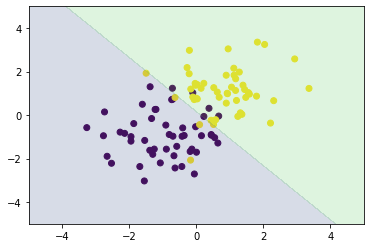

In [10]:
# 入力データの各点をクラス別に色分けしてプロットすると共に、クラスの識別等高線をプロット
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(xx0, xx1, proba.reshape(100, 100), alpha=0.2, levels=np.linspace(0, 1, 3))

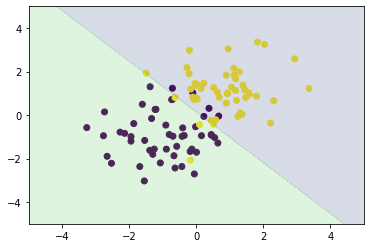

In [12]:
#sklearn実装

from sklearn.linear_model import LogisticRegression
model=LogisticRegression(fit_intercept=True)
model.fit(x_train, y_train)
proba = model.predict_proba(xx)
y_pred = (proba > 0.5).astype(np.int)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(xx0, xx1, proba[:, 0].reshape(100, 100), alpha=0.2, levels=np.linspace(0, 1, 3))